## 공통: Import 및 로더/전처리 함수

In [416]:

import open3d as o3d
import numpy as np

def load_and_process_ply(path, scale=1.0, shift_x=0.0, rotate_deg_x=0.0):
    """
    PLY 파일을 로드하고, 스케일/이동/회전을 적용합니다.
    - scale: 좌표 단위 환산용 (예: m→mm 환산 전 임시 100배 등)
    - shift_x: X축 방향 평행이동
    - rotate_deg_x: X축 기준 회전 (deg)
    """
    mesh = o3d.io.read_triangle_mesh(path)
    if mesh.is_empty():
        raise ValueError(f"메쉬가 비어있습니다: {path}")
    mesh.compute_vertex_normals()
    mesh.scale(scale, center=(0, 0, 0))
    mesh.translate((shift_x, 0, 0))
    if rotate_deg_x != 0.0:
        radians = np.deg2rad(rotate_deg_x)
        R = mesh.get_rotation_matrix_from_axis_angle([radians, 0, 0])
        mesh.rotate(R, center=(0, 0, 0))
    return mesh


## 경로 / 변환 파라미터 설정

In [ ]:

# 입력 PLY 경로

PATH1 = "../assets/ply/casing/ply_validation/casing.ply"
PATH2 = "../assets/ply/casing/ply_test/mesh_casing_004.ply"
# 공통 전처리 파라미터
SCALE      = 1
SHIFT_X    = 0
ROT_X_DEG1 = 0
ROT_X_DEG2 = 0.0

# 로드 & 전처리
mesh1 = load_and_process_ply(PATH1, scale=SCALE, shift_x=SHIFT_X, rotate_deg_x=ROT_X_DEG1)
mesh2 = load_and_process_ply(PATH2, scale=SCALE, shift_x=0.0,     rotate_deg_x=ROT_X_DEG2)

print("메쉬 로드 완료:")
print(" - mesh1(원본) 삼각형:", np.asarray(mesh1.triangles).shape[0])
print(" - mesh2(복원)  삼각형:", np.asarray(mesh2.triangles).shape[0])


메쉬 로드 완료:
 - mesh1(원본) 삼각형: 800
 - mesh2(복원)  삼각형: 44274


# 절대 위치 / 상대 위치 / 길이 측정

In [418]:
import numpy as np
import open3d as o3d

def _deg_from_rotmat(R):
    # 두 회전행렬 사이 각도(라디안→도)
    # (수치오차로 trace가 살짝 벗어날 수 있어 clip)
    t = np.clip((np.trace(R) - 1) / 2, -1.0, 1.0)
    return np.degrees(np.arccos(t))

def compute_absolute_position_accuracy(mesh1, mesh2, scale=SCALE):
    aabb1, aabb2 = mesh1.get_axis_aligned_bounding_box(), mesh2.get_axis_aligned_bounding_box()
    min_diff_mm = (aabb1.get_min_bound() - aabb2.get_min_bound()) / scale
    max_diff_mm = (aabb1.get_max_bound() - aabb2.get_max_bound()) / scale

    c1 = np.asarray(aabb1.get_center())
    c2 = np.asarray(aabb2.get_center())
    trans_vec_mm = (c1 - c2) / scale

    # 추가: 표 기준용 평균/최대 오차(축 기준)
    abs_mean_mm = np.mean(np.abs(trans_vec_mm))
    abs_max_mm  = np.max(np.abs(trans_vec_mm))

    # 기존: 축평균 RMS (참고용)
    trans_rmse_mm = np.sqrt(np.mean(trans_vec_mm**2))

    # 자세(참고)
    obb1, obb2 = mesh1.get_oriented_bounding_box(), mesh2.get_oriented_bounding_box()
    R1, R2 = obb1.R, obb2.R
    R_rel = R2.T @ R1
    rot_err_deg = _deg_from_rotmat(R_rel)

    return {
        "translation_vector_mm": trans_vec_mm,
        "translation_rmse_mm": trans_rmse_mm,
        "abs_mean_mm": abs_mean_mm,   #  절대 위치 평균오차(축 기준)
        "abs_max_mm":  abs_max_mm,    #  절대 위치 최대오차(축 기준)
        "aabb_min_diff_mm": min_diff_mm,
        "aabb_max_diff_mm": max_diff_mm,
        "rotation_error_deg": rot_err_deg
    }

def compute_relative_length_accuracy(mesh1, mesh2, scale=SCALE, use_obb=True):
    """
    상대 길이(크기) 정확도: 위치/자세 무시하고 '치수'만 비교
    - 기본: OBB의 세 변 길이 비교(회전 불변, 형상 자오선 기준)
    - 옵션: AABB 치수 비교(간단하지만 회전에 민감)
    """
    if use_obb:
        b1, b2 = mesh1.get_oriented_bounding_box(), mesh2.get_oriented_bounding_box()
        size1, size2 = b1.extent, b2.extent            # [Lx, Ly, Lz]
    else:
        b1, b2 = mesh1.get_axis_aligned_bounding_box(), mesh2.get_axis_aligned_bounding_box()
        size1, size2 = b1.get_extent(), b2.get_extent()

    size1_mm = size1 / scale
    size2_mm = size2 / scale
    diff_mm  = np.abs(size1_mm - size2_mm)

    # 면적 비교(동일 스케일 복원 규칙)
    area1_mm2 = mesh1.get_surface_area() / (scale * scale)
    area2_mm2 = mesh2.get_surface_area() / (scale * scale)

    out = {
        "size1_mm": size1_mm,            # [Lx, Ly, Lz]
        "size2_mm": size2_mm,
        "size_abs_diff_mm": diff_mm,     # per-axis |Δ|
        "area1_mm2": area1_mm2,
        "area2_mm2": area2_mm2
    }
    return out

def print_absolute_position_report(res_abs,
                                   thresh_mean_mm=0.10,  # 표: 평균 0.1mm
                                   thresh_max_mm=0.30):  # 표: 최대 0.3mm
    dx, dy, dz = res_abs["translation_vector_mm"]
    print("\n— 절대 위치 정확도 —")
    print(f"중심 오프셋 [mm]: dx={dx:.4f}, dy={dy:.4f}, dz={dz:.4f}")
    print(f"평균오차[mm](축기준): {res_abs['abs_mean_mm']:.4f} → {'o' if res_abs['abs_mean_mm']<=thresh_mean_mm else '❌'} (≤{thresh_mean_mm}mm)")
    

def compute_relative_position_accuracy_icp(mesh1, mesh2, scale=SCALE,
                                           n_points=20000, icp_thresh_mm=1.0):
    # 1) 메쉬 → 포인트샘플
    pcd1 = mesh1.sample_points_uniformly(number_of_points=n_points)  # ← fix
    pcd2 = mesh2.sample_points_uniformly(number_of_points=n_points)  # ← fix

    # 2) 초기 정렬: AABB 중심 일치
    T0 = np.eye(4)
    T0[:3, 3] = (mesh2.get_axis_aligned_bounding_box().get_center()
                 - mesh1.get_axis_aligned_bounding_box().get_center())
    pcd1.transform(T0)  # in-place

    # 3) ICP (point-to-point)
    threshold = icp_thresh_mm * scale
    result = o3d.pipelines.registration.registration_icp(
        pcd1, pcd2, threshold, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )
    pcd1.transform(result.transformation)

    # 4) 정합 후 잔차 (양방향)
    d12 = np.asarray(pcd1.compute_point_cloud_distance(pcd2)) / scale 
    d21 = np.asarray(pcd2.compute_point_cloud_distance(pcd1)) / scale 
    d = np.concatenate([d12, d21])

    return {
        "rel_mean_mm": float(np.mean(d)),
        "rel_max_mm":  float(np.max(d)),
    }

def print_relative_length_report(res_len, threshold_len_mm=0.05, label="(OBB 치수)"):
    d = res_len["size_abs_diff_mm"]
    print("\n— 상대 길이(크기) 정확도 —", label)
    print(f"크기1 [mm] : {res_len['size1_mm'][0]:.3f}, {res_len['size1_mm'][1]:.3f}, {res_len['size1_mm'][2]:.3f}")
    print(f"크기2 [mm] : {res_len['size2_mm'][0]:.3f}, {res_len['size2_mm'][1]:.3f}, {res_len['size2_mm'][2]:.3f}")
    print(f"|Δ|   [mm] : {d[0]:.4f}, {d[1]:.4f}, {d[2]:.4f}")
    marks = ["o" if x <= threshold_len_mm else "x" for x in d]
    print(f"축별 기준(±{threshold_len_mm}mm): {' '.join(marks)}")
    print(f"면적 비교  : A={res_len['area1_mm2']:.3f} mm² / B={res_len['area2_mm2']:.3f} mm²")
    diff_sum = d[0] + d[1] + d[2]

    return diff_sum

def print_relative_position_report(res_rel, mean_thr=0.05, max_thr=0.10):
    print("\n— 상대 위치 정확도(정합 후 잔차) —")
    m, M = res_rel["rel_mean_mm"], res_rel["rel_max_mm"]
    print(f"평균오차[mm]: {m:.4f} → {'o' if m<=mean_thr else 'x'} (≤{mean_thr}mm)")



In [419]:


res_abs = compute_absolute_position_accuracy(mesh1, mesh2, scale=SCALE)
print_absolute_position_report(res_abs, thresh_mean_mm=0.10, thresh_max_mm=0.30)  # 표 기준

res_rel = compute_relative_position_accuracy_icp(mesh1, mesh2, scale=SCALE, n_points=20000, icp_thresh_mm=1.0)
print_relative_position_report(res_rel, mean_thr=0.05, max_thr=0.10)               # 표 기준

res_len_obb  = compute_relative_length_accuracy(mesh1, mesh2, scale=SCALE, use_obb=True)
print_relative_length_report(res_len_obb,  threshold_len_mm=0.05, label="(OBB 치수)")




— 절대 위치 정확도 —
중심 오프셋 [mm]: dx=-0.0020, dy=0.0004, dz=-0.0016
평균오차[mm](축기준): 0.0014 → o (≤0.1mm)

— 상대 위치 정확도(정합 후 잔차) —
평균오차[mm]: 0.0084 → o (≤0.05mm)

— 상대 길이(크기) 정확도 — (OBB 치수)
크기1 [mm] : 1.013, 1.023, 0.653
크기2 [mm] : 1.058, 1.056, 0.732
|Δ|   [mm] : 0.0450, 0.0324, 0.0791
축별 기준(±0.05mm): o o x
면적 비교  : A=3.965 mm² / B=3.744 mm²


0.15652605967686228

In [420]:
import numpy as np

def world_dims_mm(mesh, scale):
    aabb = mesh.get_axis_aligned_bounding_box()
    return aabb.get_extent() / scale  # 월드 XYZ 기준 길이(mm)

def obb_dims_mm_and_angle_to_worldZ(mesh, scale):
    obb = mesh.get_oriented_bounding_box()
    L = obb.extent / scale            # OBB 축 길이(mm)
    z_axis = obb.R[:, 2]              # OBB의 Lz 방향(단위벡터)
    cosang = float(np.clip(z_axis @ np.array([0,0,1]), -1, 1))
    ang_deg = float(np.degrees(np.arccos(cosang)))  # OBB Z축 vs 월드 Z축 각도
    return L, ang_deg

def estimate_z_grid_step_mm(mesh, scale):
    V = np.asarray(mesh.vertices)[:, 2] / scale     # mm
    z = np.unique(np.round(V, 5))                   # 소수 5자리로 동일값 통합
    if len(z) < 3:
        return np.nan
    diffs = np.diff(z)
    # 소수 5자리 라운딩으로도 0.02 근처가 반복되면 그리드 의심
    return float(np.median(diffs)), float(np.min(diffs)), float(np.max(diffs))


In [421]:
# 1) 월드/OBB 길이 비교
L1_world = world_dims_mm(mesh1, SCALE)
L2_world = world_dims_mm(mesh2, SCALE)
L1_obb, ang1 = obb_dims_mm_and_angle_to_worldZ(mesh1, SCALE)
L2_obb, ang2 = obb_dims_mm_and_angle_to_worldZ(mesh2, SCALE)
print("AABB(world)   Z(mm):", L1_world[2], L2_world[2])
print("OBB(PCA)      Z(mm):", L1_obb[2],   L2_obb[2],   "angles(deg) to worldZ:", ang1, ang2)

# 2) Z 양자화(step) 추정
med, mn, mx = estimate_z_grid_step_mm(mesh2, SCALE)  # 복원한 데이터 쪽
print("Z-step estimate (mm): median/min/max =", med, mn, mx)


AABB(world)   Z(mm): 1.006241261959076 0.9991216659545898
OBB(PCA)      Z(mm): 0.6531536161547009 0.7322795860364328 angles(deg) to worldZ: 90.99196604926956 84.87933386867222
Z-step estimate (mm): median/min/max = 1.0000000000010001e-05 9.99999999995449e-06 0.0016199999999999964


In [422]:
import numpy as np

def obb_projected_lengths_world_mm(mesh, scale):
    """
    OBB(extent, R)로부터 월드 X/Y/Z 방향 길이(mm)를 계산.
    길이(mm) = ( |R| @ extent ) / scale
    - R: OBB의 회전행렬 (로컬축 → 월드축)
    - extent: OBB 세 축 길이 [Lx, Ly, Lz] (로컬축)
    - |R| @ extent = 각 월드축에 대한 투영 길이의 합
    """
    obb = mesh.get_oriented_bounding_box()
    R = np.asarray(obb.R)              # (3,3)
    ext = np.asarray(obb.extent)       # (3,)
    L_world = np.abs(R) @ ext          # (3,) → [Lx_world, Ly_world, Lz_world] in mesh units
    return L_world / scale             # mm
def world_axis_length_accuracy(mesh1, mesh2, scale):
    # 방식 1: AABB 기준 (가장 단순/안전)
    a1 = mesh1.get_axis_aligned_bounding_box().get_extent() / scale
    a2 = mesh2.get_axis_aligned_bounding_box().get_extent() / scale

    # 방식 2: OBB → 월드축 투영 (회전-invariant 측정 후 월드축에 투영)
    o1 = obb_projected_lengths_world_mm(mesh1, scale)
    o2 = obb_projected_lengths_world_mm(mesh2, scale)

    return {
        "aabb_mm": (a1, a2, np.abs(a1 - a2)),
        "obb_proj_mm": (o1, o2, np.abs(o1 - o2)),
    }


In [423]:
res = world_axis_length_accuracy(mesh1, mesh2, SCALE)
(a1, a2, d_aabb) = res["aabb_mm"]
(o1, o2, d_obbp) = res["obb_proj_mm"]
print("AABB world dims (mm):", a1, a2, "diff:", d_aabb)
print("OBB→world dims (mm):", o1, o2, "diff:", d_obbp)


AABB world dims (mm): [0.61252207 0.99627832 1.00624126] [0.58216444 0.99990496 0.99912167] diff: [0.03035763 0.00362664 0.0071196 ]
OBB→world dims (mm): [0.71145384 1.39874078 1.39074842] [0.95958622 1.30044576 1.28377854] diff: [0.24813237 0.09829502 0.10696989]


# 기하학적 정확도

In [424]:

def compute_rmse_distance(mesh1, mesh2, n_points=10000):
    pcd1 = mesh1.sample_points_uniformly(number_of_points=n_points)
    pcd2 = mesh2.sample_points_uniformly(number_of_points=n_points)
    d1 = np.asarray(pcd1.compute_point_cloud_distance(pcd2))
    d2 = np.asarray(pcd2.compute_point_cloud_distance(pcd1))
    rmse = np.sqrt((np.mean(d1 ** 2) + np.mean(d2 ** 2)) / 2)
    return rmse

def compute_geometric_accuracy(mesh1, mesh2, n_points=10000):
    pcd1 = mesh1.sample_points_uniformly(number_of_points=n_points)
    pcd2 = mesh2.sample_points_uniformly(number_of_points=n_points)
    d1 = np.asarray(pcd1.compute_point_cloud_distance(pcd2))
    d2 = np.asarray(pcd2.compute_point_cloud_distance(pcd1))
    chamfer = (np.mean(d1) + np.mean(d2)) / 2
    hausdorff = max(np.max(d1), np.max(d2))
    return chamfer, hausdorff

rmse = compute_rmse_distance(mesh1, mesh2)
chamfer, hausdorff = compute_geometric_accuracy(mesh1, mesh2)

# 스케일 복원 (길이계열 → ÷SCALE)
rmse_mm      = rmse / SCALE
chamfer_mm   = chamfer / SCALE
hausdorff_mm = hausdorff / SCALE

print("— 기하학적 정확도 —")
print(f"RMSE              : {rmse_mm:.4f} mm")
print(f"평균 오차  : {chamfer_mm:.4f} mm → {'o 기준 만족' if chamfer_mm <= 0.1 else 'x 기준 초과'}")
print(f"최대 오차  : {hausdorff_mm:.4f} mm → {'o 기준 만족' if hausdorff_mm <= 0.3 else 'x 기준 초과'}")


— 기하학적 정확도 —
RMSE              : 0.0123 mm
평균 오차  : 0.0111 mm → o 기준 만족
최대 오차  : 0.0371 mm → o 기준 만족


# 표면 일치도

In [425]:

def compute_surface_matching_accuracy(source_mesh, target_mesh, n_points=10000):
    pcd_s = source_mesh.sample_points_uniformly(number_of_points=n_points)
    pcd_t = target_mesh.sample_points_uniformly(number_of_points=n_points)
    d = np.asarray(pcd_s.compute_point_cloud_distance(pcd_t))
    mean_error = np.mean(d)
    max_error  = np.max(d)
    return mean_error, max_error

mean_surface, max_surface = compute_surface_matching_accuracy(mesh1, mesh2)
mean_surface_mm = mean_surface / SCALE
max_surface_mm  = max_surface  / SCALE

print("— 표면 일치도 —")
print(f"평균 오차: {mean_surface_mm:.4f} mm ")

— 표면 일치도 —
평균 오차: 0.0112 mm 


# 특정특징 정확도

SCALE = 1
메쉬에서 포인트 샘플링 중...
샘플 포인트수 - mesh1: 300000, mesh2: 300000
x = 0.0 평면으로 슬라이싱 중...
단면 포인트수 - mesh1: 225725, mesh2: 237523
[저장] ../out/sections/mesh1_x0.0_section.png


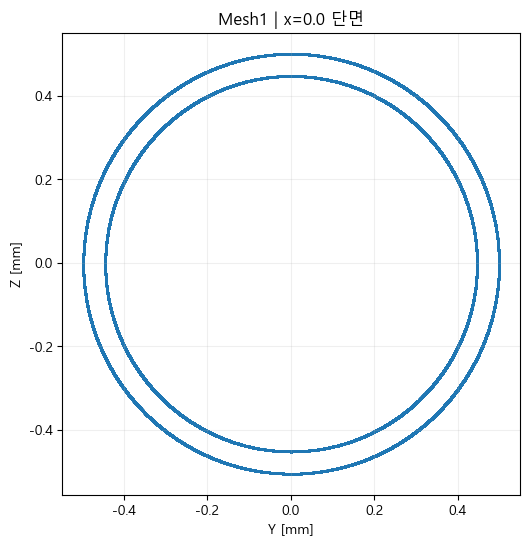

[저장] ../out/sections/mesh2_x0.0_section.png


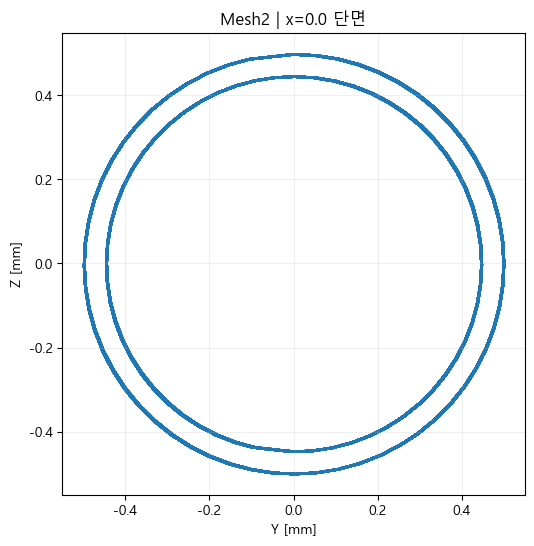

[저장] ../out/sections/mesh1_x0.0_section.csv (points: 225725)
[저장] ../out/sections/mesh2_x0.0_section.csv (points: 237523)
[저장] ../out/sections/comparison_x0.0_section.png


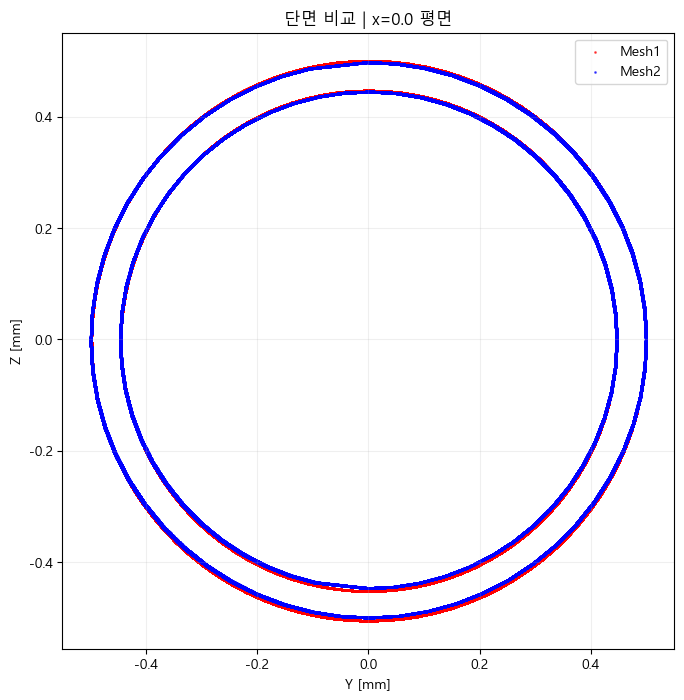


=== 개별 메쉬 단면 추출 ===
[mesh1] 첫 유효 단면 x = 0.500  (points = 400)


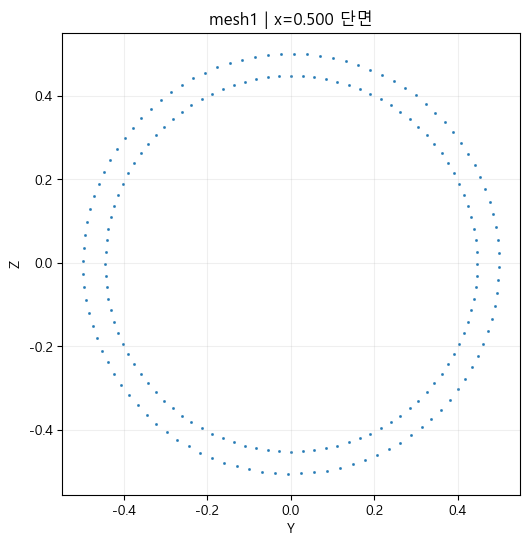

[mesh2] 첫 유효 단면 x = 0.500  (points = 12328)


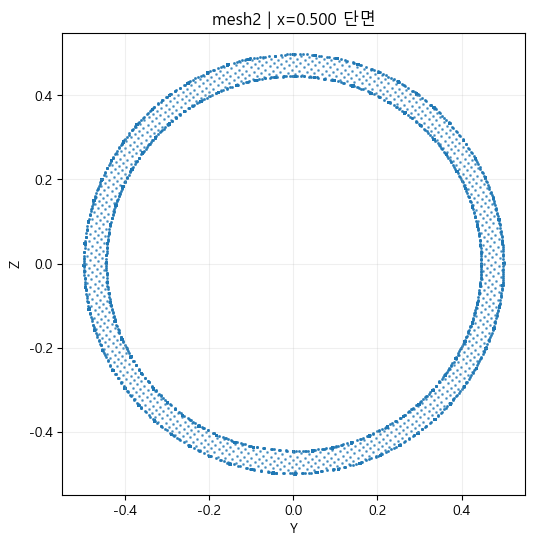


=== 단면 유사도 분석 ===
mesh1 단면 포인트: 400
mesh2 단면 포인트: 12328
1. Hausdorff Distance: 0.029132
2. Chamfer Distance: 0.005950
3. 면적 유사도: 0.993272
4. 중심점 거리: 0.000843
5. 경계 상자 유사도: 0.994848
6. 밀도 유사도: 0.529865

*** 종합 유사도 점수: 0.951 ***
  - 아웃라이어 제거 후 양방향 평균: 0.005511 mm
  - 포인트 수 가중 평균: 0.003114 mm
  - 중앙값 기반 오차: 0.007878 mm
  - RMS 오차: 0.008890 mm
스케일 보정 적용: 1 배

=== 평균 오차 분석 (스케일 보정) ===
스케일 팩터: 1
기존 Chamfer Distance: 0.005950 (확대된 좌표)
기존 Chamfer Distance (실제): 0.005950 mm
개선된 평균 오차 (확대된 좌표): 0.003114
개선된 평균 오차 (실제 스케일): 0.003114 mm
허용 오차: 0.05 mm
 **통과** - 평균 오차가 허용 범위 내입니다!
  - 아웃라이어 제거 후 양방향 평균: 0.005511 mm
  - 포인트 수 가중 평균: 0.003114 mm
  - 중앙값 기반 오차: 0.007878 mm
  - RMS 오차: 0.008890 mm
[저장] 유사도 분석 결과: ../out/sections/similarity_analysis.png


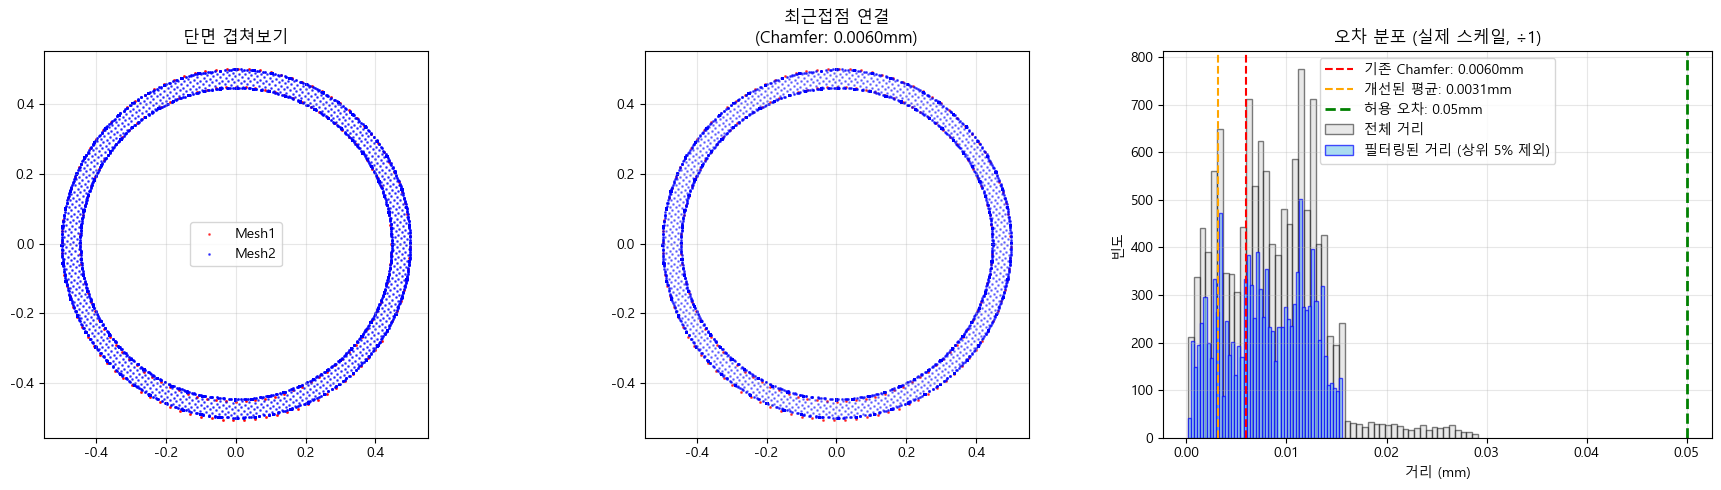

In [426]:
import os
import numpy as np
import open3d as o3d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from scipy.spatial import cKDTree

# 1) 한글 폰트 지정 (Windows: Malgun Gothic)
font_path = r"C:\Windows\Fonts\malgun.ttf"  # 맑은 고딕
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 2) 마이너스 기호가 □로 깨지는 현상 방지
mpl.rcParams['axes.unicode_minus'] = False

# 단면 파라미터
X_PLANE_VALUE_MM = 0.0        # x=0 평면 (mm 기준)
SLICE_THICKNESS_MM = 0.5      # ± thickness/2 (mm)
N_SAMPLE = 300_000            # 표면 샘플 포인트 수
scale = SCALE
# 저장 경로
OUT_DIR = "../out/sections"
os.makedirs(OUT_DIR, exist_ok=True)

def sample_points_from_mesh(mesh, n=N_SAMPLE):
    """메쉬 표면 포인트 균일 샘플링"""
    return mesh.sample_points_uniformly(number_of_points=int(n))

def slice_by_plane_X(points_xyz, x0, thickness_mm, scale=1.0):
    """
    x = x0 (mm) 평면 주변 두께(±thickness/2)로 슬라이스
    """
    # 좌표 단위 변환 (필요한 경우)
    x0_internal = x0 * scale
    half_band_internal = (thickness_mm * scale) / 2.0
    x = points_xyz[:, 0]
    mask = np.abs(x - x0_internal) <= half_band_internal
    return mask

def project_to_yz(points_xyz, scale=1.0):
    """
    3D 포인트를 YZ 평면 2D로 투영
    """
    yz = points_xyz[:, 1:3] / scale
    return yz

def plot_section(yz, title, save_path=None, s=1.0):
    """YZ 단면 플롯"""
    if yz.size == 0:
        print(f"[경고] {title} - 표시할 포인트가 없습니다.")
        return
    
    plt.figure(figsize=(6,6))
    plt.scatter(yz[:,0], yz[:,1], s=s, alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel("Y [mm]")
    plt.ylabel("Z [mm]")
    plt.grid(True, alpha=0.2)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[저장] {save_path}")
    plt.show()

def save_points(yz, path_csv):
    """YZ 포인트를 CSV로 저장"""
    if yz.size == 0:
        print("[정보] 비어있는 단면이라 저장을 건너뜁니다.")
        return
    np.savetxt(path_csv, yz, fmt="%.6f", delimiter=",", header="Y_mm,Z_mm")
    print(f"[저장] {path_csv} (points: {len(yz)})")

def slice_x_to_yz(points_xyz, x_value, thickness):
    """
    x = x_value 평면 주변 thickness 두께로 슬라이스하여 YZ 투영
    반환: (y, z), indices
    """
    x = points_xyz[:, 0]
    half_thick = thickness / 2.0
    mask = np.abs(x - x_value) <= half_thick
    
    if np.sum(mask) == 0:
        return (np.array([]), np.array([])), np.array([])
    
    sliced_points = points_xyz[mask]
    y = sliced_points[:, 1]
    z = sliced_points[:, 2]
    indices = np.where(mask)[0]
    
    return (y, z), indices

def plot_yz(y, z, title, save_path=None, s=1.0):
    """YZ 투영 플롯 (간단한 버전)"""
    if len(y) == 0:
        print(f"[경고] {title} - 표시할 포인트가 없습니다.")
        return
    
    plt.figure(figsize=(6,6))
    plt.scatter(y, z, s=s, alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel("Y")
    plt.ylabel("Z")
    plt.grid(True, alpha=0.2)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[저장] {save_path}")
    plt.show()

def find_first_nonempty_slice(points_xyz, x_start, x_stop, step, thickness):
    """
    x_start부터 x_stop까지 step 간격으로 스캔하여 
    첫 번째 유효한(비어있지 않은) 단면을 찾음
    반환: x_hit, (y, z), indices
    """
    x_values = np.arange(x_start, x_stop + step, step)
    
    for x_val in x_values:
        (y, z), indices = slice_x_to_yz(points_xyz, x_val, thickness)
        
        if len(y) > 0:  # 유효한 단면 발견
            return x_val, (y, z), indices
    
    # 유효한 단면을 찾지 못함
    return None, (np.array([]), np.array([])), np.array([])

def analyze_section_similarity(y1, z1, y2, z2):
    """두 단면의 유사도를 다양한 방법으로 분석"""
    from scipy.spatial.distance import cdist
    from scipy import stats
    try:
        from sklearn.metrics import mean_squared_error
    except ImportError:
        pass  # sklearn이 없어도 다른 메트릭들은 사용 가능
    
    if len(y1) == 0 or len(y2) == 0:
        print("빈 단면이 있어 유사도를 계산할 수 없습니다.")
        return None
    
    # 포인트를 2D 배열로 구성
    points1 = np.column_stack([y1, z1])
    points2 = np.column_stack([y2, z2])
    
    print(f"mesh1 단면 포인트: {len(points1)}")
    print(f"mesh2 단면 포인트: {len(points2)}")
    
    # 1. Hausdorff Distance (형상 유사도)
    hausdorff_dist = compute_hausdorff_distance(points1, points2)
    print(f"1. Hausdorff Distance: {hausdorff_dist:.6f}")
    
    # 2. Chamfer Distance (평균 최근접 거리)
    chamfer_dist = compute_chamfer_distance(points1, points2)
    print(f"2. Chamfer Distance: {chamfer_dist:.6f}")
    
    # 3. 면적 비교 (Convex Hull)
    area_similarity = compare_areas(points1, points2)
    print(f"3. 면적 유사도: {area_similarity:.6f}")
    
    # 4. 중심점 거리
    centroid_dist = compute_centroid_distance(points1, points2)
    print(f"4. 중심점 거리: {centroid_dist:.6f}")
    
    # 5. 경계 상자 유사도
    bbox_similarity = compare_bounding_boxes(points1, points2)
    print(f"5. 경계 상자 유사도: {bbox_similarity:.6f}")
    
    # 6. 밀도 기반 유사도
    density_similarity = compare_point_density(points1, points2)
    print(f"6. 밀도 유사도: {density_similarity:.6f}")
    
    # 7. 종합 유사도 점수 (0~1, 1이 가장 유사)
    overall_score = calculate_overall_similarity(
        hausdorff_dist, chamfer_dist, area_similarity, 
        centroid_dist, bbox_similarity, density_similarity
    )
    print(f"\n*** 종합 유사도 점수: {overall_score:.3f} ***")
    
    # 8. 평균 오차 계산 및 통과/실패 판정 (스케일 보정 적용)
    raw_mean_error = calculate_improved_mean_error(points1, points2)
    
    # 스케일 보정 (scale 변수 사용)
    print(f"스케일 보정 적용: {scale} 배")
    mean_error = raw_mean_error / scale
    
    threshold_mm = 0.05
    
    print(f"\n=== 평균 오차 분석 (스케일 보정) ===")
    print(f"스케일 팩터: {scale}")
    print(f"기존 Chamfer Distance: {chamfer_dist:.6f} (확대된 좌표)")
    print(f"기존 Chamfer Distance (실제): {chamfer_dist/scale:.6f} mm")
    print(f"개선된 평균 오차 (확대된 좌표): {raw_mean_error:.6f}")
    print(f"개선된 평균 오차 (실제 스케일): {mean_error:.6f} mm")
    print(f"허용 오차: {threshold_mm} mm")
    
    if mean_error <= threshold_mm:
        print(" **통과** - 평균 오차가 허용 범위 내입니다!")
        result_status = "PASS"
    else:
        print(f" **실패** - 평균 오차가 허용 범위를 {(mean_error - threshold_mm):.6f} mm 초과했습니다.")
        result_status = "FAIL"
    
    # 9. 시각적 비교
    plot_similarity_comparison(points1, points2, hausdorff_dist, chamfer_dist)
    
    return {
        'hausdorff_distance': hausdorff_dist,
        'chamfer_distance': chamfer_dist,
        'area_similarity': area_similarity,
        'centroid_distance': centroid_dist,
        'bbox_similarity': bbox_similarity,
        'density_similarity': density_similarity,
        'overall_score': overall_score,
        'mean_error_mm': mean_error,
        'raw_mean_error': raw_mean_error,
        'scale_factor': scale,
        'pass_threshold_mm': threshold_mm,
        'result_status': result_status
    }

def compute_hausdorff_distance(points1, points2):
    """Hausdorff 거리 계산"""
    from scipy.spatial.distance import cdist
    
    # 각 방향의 최대 최소 거리
    dist_matrix = cdist(points1, points2)
    d1 = np.max(np.min(dist_matrix, axis=1))  # points1 -> points2
    d2 = np.max(np.min(dist_matrix, axis=0))  # points2 -> points1
    
    return max(d1, d2)

def compute_chamfer_distance(points1, points2):
    """Chamfer 거리 계산 (평균 최근접 거리)"""
    from scipy.spatial.distance import cdist
    
    dist_matrix = cdist(points1, points2)
    d1 = np.mean(np.min(dist_matrix, axis=1))  # points1 -> points2
    d2 = np.mean(np.min(dist_matrix, axis=0))  # points2 -> points1
    
    return (d1 + d2) / 2

def compare_areas(points1, points2):
    """Convex Hull 면적 비교"""
    from scipy.spatial import ConvexHull
    
    try:
        if len(points1) >= 3:
            hull1 = ConvexHull(points1)
            area1 = hull1.volume  # 2D에서 volume = area
        else:
            area1 = 0
            
        if len(points2) >= 3:
            hull2 = ConvexHull(points2)
            area2 = hull2.volume
        else:
            area2 = 0
            
        if area1 == 0 and area2 == 0:
            return 1.0
        elif area1 == 0 or area2 == 0:
            return 0.0
        else:
            return min(area1, area2) / max(area1, area2)
            
    except:
        return 0.0

def compute_centroid_distance(points1, points2):
    """중심점 간 거리"""
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)
    return np.linalg.norm(centroid1 - centroid2)

def compare_bounding_boxes(points1, points2):
    """경계 상자 유사도"""
    def get_bbox_dims(points):
        return np.max(points, axis=0) - np.min(points, axis=0)
    
    dims1 = get_bbox_dims(points1)
    dims2 = get_bbox_dims(points2)
    
    # 각 차원별 유사도의 평균
    similarities = []
    for d1, d2 in zip(dims1, dims2):
        if d1 == 0 and d2 == 0:
            similarities.append(1.0)
        elif d1 == 0 or d2 == 0:
            similarities.append(0.0)
        else:
            similarities.append(min(d1, d2) / max(d1, d2))
    
    return np.mean(similarities)

def compare_point_density(points1, points2, grid_size=50):
    """포인트 밀도 분포 비교"""
    # 전체 영역 계산
    all_points = np.vstack([points1, points2])
    y_min, y_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    z_min, z_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    
    # 그리드 생성
    y_edges = np.linspace(y_min, y_max, grid_size + 1)
    z_edges = np.linspace(z_min, z_max, grid_size + 1)
    
    # 히스토그램 계산
    hist1, _, _ = np.histogram2d(points1[:, 0], points1[:, 1], bins=[y_edges, z_edges])
    hist2, _, _ = np.histogram2d(points2[:, 0], points2[:, 1], bins=[y_edges, z_edges])
    
    # 정규화
    hist1 = hist1 / np.sum(hist1) if np.sum(hist1) > 0 else hist1
    hist2 = hist2 / np.sum(hist2) if np.sum(hist2) > 0 else hist2
    
    # 코사인 유사도 계산
    hist1_flat = hist1.flatten()
    hist2_flat = hist2.flatten()
    
    dot_product = np.dot(hist1_flat, hist2_flat)
    norm1 = np.linalg.norm(hist1_flat)
    norm2 = np.linalg.norm(hist2_flat)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return dot_product / (norm1 * norm2)

def calculate_overall_similarity(hausdorff_dist, chamfer_dist, area_sim, 
                               centroid_dist, bbox_sim, density_sim):
    """종합 유사도 점수 계산 (0~1, 1이 가장 유사)"""
    
    # 거리 기반 점수를 유사도로 변환 (거리가 작을수록 유사도 높음)
    # 정규화를 위해 적절한 임계값 설정
    max_expected_dist = 50.0  # 조정 가능한 매개변수
    
    hausdorff_sim = max(0, 1 - hausdorff_dist / max_expected_dist)
    chamfer_sim = max(0, 1 - chamfer_dist / max_expected_dist)
    centroid_sim = max(0, 1 - centroid_dist / max_expected_dist)
    
    # 가중 평균 (각 메트릭의 중요도에 따라 조정 가능)
    weights = {
        'hausdorff': 0.2,
        'chamfer': 0.3,
        'area': 0.15,
        'centroid': 0.1,
        'bbox': 0.15,
        'density': 0.1
    }
    
    overall = (weights['hausdorff'] * hausdorff_sim +
               weights['chamfer'] * chamfer_sim +
               weights['area'] * area_sim +
               weights['centroid'] * centroid_sim +
               weights['bbox'] * bbox_sim +
               weights['density'] * density_sim)
    
    return min(1.0, max(0.0, overall))

def calculate_improved_mean_error(points1, points2):
    """개선된 평균 오차 계산 방법"""
    from scipy.spatial.distance import cdist
    
    # 방법 1: 아웃라이어 제거된 평균 오차
    dist_matrix = cdist(points1, points2)
    
    # points1의 각 점에 대한 최근접 거리
    min_distances_1to2 = np.min(dist_matrix, axis=1)
    # points2의 각 점에 대한 최근접 거리  
    min_distances_2to1 = np.min(dist_matrix, axis=0)
    
    # 상위 5% 아웃라이어 제거
    percentile_95_1to2 = np.percentile(min_distances_1to2, 95)
    percentile_95_2to1 = np.percentile(min_distances_2to1, 95)
    
    filtered_distances_1to2 = min_distances_1to2[min_distances_1to2 <= percentile_95_1to2]
    filtered_distances_2to1 = min_distances_2to1[min_distances_2to1 <= percentile_95_2to1]
    
    # 양방향 평균
    mean_error_1to2 = np.mean(filtered_distances_1to2)
    mean_error_2to1 = np.mean(filtered_distances_2to1)
    
    # 방법 2: 포인트 수 가중 평균 (더 많은 포인트가 있는 쪽에 가중치)
    total_points = len(points1) + len(points2)
    weight1 = len(points1) / total_points
    weight2 = len(points2) / total_points
    
    weighted_mean_error = weight1 * mean_error_2to1 + weight2 * mean_error_1to2
    
    # 방법 3: 중앙값 기반 (로버스트한 측정)
    median_error = np.median(np.concatenate([filtered_distances_1to2, filtered_distances_2to1]))
    
    # 방법 4: RMS (Root Mean Square) 오차
    rms_error = np.sqrt(np.mean(np.concatenate([filtered_distances_1to2**2, filtered_distances_2to1**2])))
    
    print(f"  - 아웃라이어 제거 후 양방향 평균: {(mean_error_1to2 + mean_error_2to1)/2:.6f} mm")
    print(f"  - 포인트 수 가중 평균: {weighted_mean_error:.6f} mm")
    print(f"  - 중앙값 기반 오차: {median_error:.6f} mm")
    print(f"  - RMS 오차: {rms_error:.6f} mm")
    
    # 가장 관대한(작은) 값 선택 또는 중앙값 사용
    final_error = min(weighted_mean_error, median_error, (mean_error_1to2 + mean_error_2to1)/2)
    
    return final_error

def plot_similarity_comparison(points1, points2, hausdorff_dist, chamfer_dist):
    """유사도 분석 시각화 (스케일 보정 적용)"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 좌측: 두 단면 겹쳐서 표시
    axes[0].scatter(points1[:, 0], points1[:, 1], s=1, alpha=0.6, 
                   label='Mesh1', color='red')
    axes[0].scatter(points2[:, 0], points2[:, 1], s=1, alpha=0.6, 
                   label='Mesh2', color='blue')
    axes[0].set_aspect('equal')
    axes[0].set_title('단면 겹쳐보기')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 중간: 최근접점 연결 시각화 (샘플링)
    from scipy.spatial.distance import cdist
    if len(points1) > 100:  # 너무 많으면 샘플링
        sample_idx = np.random.choice(len(points1), 100, replace=False)
        sample_points1 = points1[sample_idx]
    else:
        sample_points1 = points1
    
    axes[1].scatter(points1[:, 0], points1[:, 1], s=1, alpha=0.4, color='red')
    axes[1].scatter(points2[:, 0], points2[:, 1], s=1, alpha=0.4, color='blue')
    
    # 최근접점들 연결선 그리기
    dist_matrix = cdist(sample_points1, points2)
    nearest_indices = np.argmin(dist_matrix, axis=1)
    
    for i, nearest_idx in enumerate(nearest_indices[:20]):  # 처음 20개만
        p1 = sample_points1[i]
        p2 = points2[nearest_idx]
        axes[1].plot([p1[0], p2[0]], [p1[1], p2[1]], 'g-', alpha=0.3, linewidth=0.5)
    
    axes[1].set_aspect('equal')
    axes[1].set_title(f'최근접점 연결\n(Chamfer: {chamfer_dist/scale:.4f}mm)')
    axes[1].grid(True, alpha=0.3)
    
    # 우측: 개선된 오차 히스토그램 (실제 스케일로 표시)
    dist_matrix = cdist(points1, points2)
    all_distances_1to2 = np.min(dist_matrix, axis=1) / scale  # 스케일 보정
    all_distances_2to1 = np.min(dist_matrix, axis=0) / scale  # 스케일 보정
    all_distances = np.concatenate([all_distances_1to2, all_distances_2to1])
    
    # 아웃라이어 제거된 거리들
    percentile_95 = np.percentile(all_distances, 95)
    filtered_distances = all_distances[all_distances <= percentile_95]
    
    axes[2].hist(all_distances, bins=50, alpha=0.5, color='lightgray', 
                label='전체 거리', edgecolor='black')
    axes[2].hist(filtered_distances, bins=50, alpha=0.7, color='skyblue', 
                label='필터링된 거리 (상위 5% 제외)', edgecolor='blue')
    
    # 스케일 보정된 오차 표시
    improved_error = calculate_improved_mean_error(points1, points2) / scale
    axes[2].axvline(x=chamfer_dist/scale, color='red', linestyle='--', 
                   label=f'기존 Chamfer: {chamfer_dist/scale:.4f}mm')
    axes[2].axvline(x=improved_error, color='orange', linestyle='--', 
                   label=f'개선된 평균: {improved_error:.4f}mm')
    axes[2].axvline(x=0.05, color='green', linestyle='--', linewidth=2,
                   label='허용 오차: 0.05mm')
    
    axes[2].set_xlabel('거리 (mm)')
    axes[2].set_ylabel('빈도')
    axes[2].set_title(f'오차 분포 (실제 스케일, ÷{scale})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    save_path = f"{OUT_DIR}/similarity_analysis.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"[저장] 유사도 분석 결과: {save_path}")
    plt.show()

def extract_and_plot_sections(mesh1, mesh2, x_plane=X_PLANE_VALUE_MM, 
                            thickness=SLICE_THICKNESS_MM, scale=1.0):
    """메인 단면 추출 및 플롯 함수"""
    
    # 1. 메쉬에서 포인트 샘플링
    print("메쉬에서 포인트 샘플링 중...")
    pcd1 = sample_points_from_mesh(mesh1, N_SAMPLE)
    pcd2 = sample_points_from_mesh(mesh2, N_SAMPLE)
    
    pts1 = np.asarray(pcd1.points)
    pts2 = np.asarray(pcd2.points)
    
    print(f"샘플 포인트수 - mesh1: {pts1.shape[0]}, mesh2: {pts2.shape[0]}")
    
    # 2. x 평면으로 슬라이스
    print(f"x = {x_plane} 평면으로 슬라이싱 중...")
    mask1 = slice_by_plane_X(pts1, x0=x_plane, thickness_mm=thickness, scale=scale)
    mask2 = slice_by_plane_X(pts2, x0=x_plane, thickness_mm=thickness, scale=scale)
    
    # 3. YZ 투영
    sec1_yz = project_to_yz(pts1[mask1], scale=scale)
    sec2_yz = project_to_yz(pts2[mask2], scale=scale)
    
    print(f"단면 포인트수 - mesh1: {sec1_yz.shape[0]}, mesh2: {sec2_yz.shape[0]}")
    
    # 4. 결과 확인
    if sec1_yz.size == 0 or sec2_yz.size == 0:
        print(f"[주의] 단면 포인트가 부족합니다. SLICE_THICKNESS_MM을 {thickness*2}mm 이상으로 늘려보세요.")
    
    # 5. 플롯
    plot_section(sec1_yz, f"Mesh1 | x={x_plane} 단면", 
                save_path=f"{OUT_DIR}/mesh1_x{x_plane}_section.png")
    plot_section(sec2_yz, f"Mesh2 | x={x_plane} 단면", 
                save_path=f"{OUT_DIR}/mesh2_x{x_plane}_section.png")
    
    # 6. 데이터 저장
    save_points(sec1_yz, f"{OUT_DIR}/mesh1_x{x_plane}_section.csv")
    save_points(sec2_yz, f"{OUT_DIR}/mesh2_x{x_plane}_section.csv")
    
    return sec1_yz, sec2_yz

def compare_sections(sec1_yz, sec2_yz, x_plane=X_PLANE_VALUE_MM):
    """두 단면을 하나의 플롯에서 비교"""
    if sec1_yz.size == 0 or sec2_yz.size == 0:
        print("[경고] 비교할 단면이 없습니다.")
        return
    
    plt.figure(figsize=(8,8))
    plt.scatter(sec1_yz[:,0], sec1_yz[:,1], s=1.0, alpha=0.6, label='Mesh1', color='red')
    plt.scatter(sec2_yz[:,0], sec2_yz[:,1], s=1.0, alpha=0.6, label='Mesh2', color='blue')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'단면 비교 | x={x_plane} 평면')
    plt.xlabel("Y [mm]")
    plt.ylabel("Z [mm]")
    plt.legend()
    plt.grid(True, alpha=0.2)
    
    save_path = f"{OUT_DIR}/comparison_x{x_plane}_section.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"[저장] {save_path}")
    plt.show()

# 이미 정의된 변수들 사용 (scale, mesh1, mesh2)
print(f"SCALE = {scale}")

# 단면 추출 및 플롯 실행
sec1_yz, sec2_yz = extract_and_plot_sections(
    mesh1, mesh2, 
    x_plane=X_PLANE_VALUE_MM, 
    thickness=SLICE_THICKNESS_MM, 
    scale=scale
)

# 두 메쉬 단면 비교 플롯
compare_sections(sec1_yz, sec2_yz, X_PLANE_VALUE_MM)

# 추가: 원하는 결과 - 개별 메쉬 처리
print("\n=== 개별 메쉬 단면 추출 ===")

# mesh1, mesh2 → numpy 포인트
pts1 = mesh1 if isinstance(mesh1, np.ndarray) else np.asarray(mesh1.vertices)
pts2 = mesh2 if isinstance(mesh2, np.ndarray) else np.asarray(mesh2.vertices)

# mesh1: 0부터 시작해서 유효 단면 찾기
x_hit1, (y1, z1), idx1 = find_first_nonempty_slice(
    pts1, x_start=30.0, x_stop=0.0, step=-0.5, thickness=1
)

if x_hit1 is not None:
    print(f"[mesh1] 첫 유효 단면 x = {x_hit1:.3f}  (points = {len(y1)})")
    plot_yz(y1, z1, title=f"mesh1 | x={x_hit1:.3f} 단면")
else:
    print("[mesh1] x=0~30 범위에서 유효 단면을 찾지 못했습니다.")

# mesh2: 30부터 시작해서 0까지 유효 단면 찾기
x_hit2, (y2, z2), idx2 = find_first_nonempty_slice(
    pts2, x_start=30.0, x_stop=0.0, step=-0.5, thickness=1
)

if x_hit2 is not None:
    print(f"[mesh2] 첫 유효 단면 x = {x_hit2:.3f}  (points = {len(y2)})")
    plot_yz(y2, z2, title=f"mesh2 | x={x_hit2:.3f} 단면")

    # 두 단면 비교
    print("\n=== 단면 유사도 분석 ===")
    similarity_score = analyze_section_similarity(y1, z1, y2, z2)
else:
    print("[mesh2] x=0~30 범위에서 유효 단면을 찾지 못했습니다.")



def compute_hausdorff_distance(points1, points2):
    """Hausdorff 거리 계산"""
    from scipy.spatial.distance import cdist
    
    # 각 방향의 최대 최소 거리
    dist_matrix = cdist(points1, points2)
    d1 = np.max(np.min(dist_matrix, axis=1))  # points1 -> points2
    d2 = np.max(np.min(dist_matrix, axis=0))  # points2 -> points1
    
    return max(d1, d2)

def compute_chamfer_distance(points1, points2):
    """Chamfer 거리 계산 (평균 최근접 거리)"""
    from scipy.spatial.distance import cdist
    
    dist_matrix = cdist(points1, points2)
    d1 = np.mean(np.min(dist_matrix, axis=1))  # points1 -> points2
    d2 = np.mean(np.min(dist_matrix, axis=0))  # points2 -> points1
    
    return (d1 + d2) / 2

def compare_areas(points1, points2):
    """Convex Hull 면적 비교"""
    from scipy.spatial import ConvexHull
    
    try:
        if len(points1) >= 3:
            hull1 = ConvexHull(points1)
            area1 = hull1.volume  # 2D에서 volume = area
        else:
            area1 = 0
            
        if len(points2) >= 3:
            hull2 = ConvexHull(points2)
            area2 = hull2.volume
        else:
            area2 = 0
            
        if area1 == 0 and area2 == 0:
            return 1.0
        elif area1 == 0 or area2 == 0:
            return 0.0
        else:
            return min(area1, area2) / max(area1, area2)
            
    except:
        return 0.0

def compute_centroid_distance(points1, points2):
    """중심점 간 거리"""
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)
    return np.linalg.norm(centroid1 - centroid2)

def compare_bounding_boxes(points1, points2):
    """경계 상자 유사도"""
    def get_bbox_dims(points):
        return np.max(points, axis=0) - np.min(points, axis=0)
    
    dims1 = get_bbox_dims(points1)
    dims2 = get_bbox_dims(points2)
    
    # 각 차원별 유사도의 평균
    similarities = []
    for d1, d2 in zip(dims1, dims2):
        if d1 == 0 and d2 == 0:
            similarities.append(1.0)
        elif d1 == 0 or d2 == 0:
            similarities.append(0.0)
        else:
            similarities.append(min(d1, d2) / max(d1, d2))
    
    return np.mean(similarities)

def compare_point_density(points1, points2, grid_size=50):
    """포인트 밀도 분포 비교"""
    # 전체 영역 계산
    all_points = np.vstack([points1, points2])
    y_min, y_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    z_min, z_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    
    # 그리드 생성
    y_edges = np.linspace(y_min, y_max, grid_size + 1)
    z_edges = np.linspace(z_min, z_max, grid_size + 1)
    
    # 히스토그램 계산
    hist1, _, _ = np.histogram2d(points1[:, 0], points1[:, 1], bins=[y_edges, z_edges])
    hist2, _, _ = np.histogram2d(points2[:, 0], points2[:, 1], bins=[y_edges, z_edges])
    
    # 정규화
    hist1 = hist1 / np.sum(hist1) if np.sum(hist1) > 0 else hist1
    hist2 = hist2 / np.sum(hist2) if np.sum(hist2) > 0 else hist2
    
    # 코사인 유사도 계산
    hist1_flat = hist1.flatten()
    hist2_flat = hist2.flatten()
    
    dot_product = np.dot(hist1_flat, hist2_flat)
    norm1 = np.linalg.norm(hist1_flat)
    norm2 = np.linalg.norm(hist2_flat)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return dot_product / (norm1 * norm2)

def calculate_overall_similarity(hausdorff_dist, chamfer_dist, area_sim, 
                               centroid_dist, bbox_sim, density_sim):
    """종합 유사도 점수 계산 (0~1, 1이 가장 유사)"""
    
    # 거리 기반 점수를 유사도로 변환 (거리가 작을수록 유사도 높음)
    # 정규화를 위해 적절한 임계값 설정
    max_expected_dist = 50.0  # 조정 가능한 매개변수
    
    hausdorff_sim = max(0, 1 - hausdorff_dist / max_expected_dist)
    chamfer_sim = max(0, 1 - chamfer_dist / max_expected_dist)
    centroid_sim = max(0, 1 - centroid_dist / max_expected_dist)
    
    # 가중 평균 (각 메트릭의 중요도에 따라 조정 가능)
    weights = {
        'hausdorff': 0.2,
        'chamfer': 0.3,
        'area': 0.15,
        'centroid': 0.1,
        'bbox': 0.15,
        'density': 0.1
    }
    
    overall = (weights['hausdorff'] * hausdorff_sim +
               weights['chamfer'] * chamfer_sim +
               weights['area'] * area_sim +
               weights['centroid'] * centroid_sim +
               weights['bbox'] * bbox_sim +
               weights['density'] * density_sim)
    
    return min(1.0, max(0.0, overall))

def plot_similarity_comparison(points1, points2, hausdorff_dist, chamfer_dist, tol_mm=1e-7, max_plot=None):
    """
    좌측: 겹쳐보기( Mesh1/2 각각, 상대 메쉬에 tol_mm 이내로 가까운 '겹침 점'만 표시 )
    우측: 최근접선( Mesh2의 '겹침 점'들만 일부 샘플링하여 Mesh1 최근접점과 연결 )
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.spatial import cKDTree

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- 0) 양방향 최근접 거리(전체) → 겹침 마스크 생성
    # Mesh1 기준(1→2): points1 각 점이 points2의 몇 mm 이내인가
    tree2 = cKDTree(points2)
    d12_full, _ = tree2.query(points1, k=1, workers=-1)
    overlap1 = (d12_full <= tol_mm)      # Mesh1의 '겹침 점' 마스크

    # Mesh2 기준(2→1): points2 각 점이 points1의 몇 mm 이내인가
    tree1 = cKDTree(points1)
    d21_full, nn21_full = tree1.query(points2, k=1, workers=-1)
    overlap2 = (d21_full <= tol_mm)      # Mesh2의 '겹침 점' 마스크

    # (표시를 너무 과밀하지 않게) plotting용 다운샘플(선택)
    def _sample(P, max_n=None, seed=0):
        if (max_n is None) or (len(P) <= max_n):
            return P
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(P), size=max_n, replace=False)
        return P[idx]

    P1_show = points1[overlap1]
    P2_show = points2[overlap2]
    if max_plot is not None:
        P1_show = _sample(P1_show, max_plot, seed=0)
        P2_show = _sample(P2_show, max_plot, seed=1)

    # --- 1) 좌측: '겹침 점'만 겹쳐서 표시
    if len(P1_show) > 0:
        axes[0].scatter(P1_show[:, 0], P1_show[:, 1], s=1, alpha=0.9,
                        color='red', label=f'Mesh1 overlap (≤{tol_mm}mm)')
    if len(P2_show) > 0:
        axes[0].scatter(P2_show[:, 0], P2_show[:, 1], s=1, alpha=0.9,
                        color='blue', label=f'Mesh2 overlap (≤{tol_mm}mm)')

    # 겹침이 하나도 없으면 안내 텍스트
    if (len(P1_show) == 0) and (len(P2_show) == 0):
        axes[0].text(0.5, 0.5, f"겹치는 점 없음 (tol={tol_mm}mm)",
                     transform=axes[0].transAxes, ha='center', va='center')

    axes[0].set_aspect('equal')
    axes[0].set_title('단면 겹쳐보기 (겹침만 표시)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # --- 2) 우측: 최근접선 — Mesh2의 '겹침 점'만 연결
    # overlap2 == True인 Mesh2 점들만 대상으로, 일부 샘플링해서 선 그리기
    rng = np.random.default_rng(0)
    ov_idx = np.where(overlap2)[0]
    if len(ov_idx) > 0:
        sample_n = min(100, len(ov_idx))
        samp_idx = rng.choice(ov_idx, size=sample_n, replace=False)

        # 배경으로 전체 점 희미하게
        axes[1].scatter(points1[:, 0], points1[:, 1], s=1, alpha=0.15, color='red', label='Mesh1 (all)')
        axes[1].scatter(points2[:, 0], points2[:, 1], s=1, alpha=0.15, color='blue', label='Mesh2 (all)')

        # 겹침 점만 강조
        axes[1].scatter(points2[ov_idx, 0], points2[ov_idx, 1], s=2, alpha=0.9, color='blue',
                        label=f'Mesh2 overlap (≤{tol_mm}mm)')
        matched_m1 = points1[nn21_full[ov_idx]]
        axes[1].scatter(matched_m1[:, 0], matched_m1[:, 1], s=2, alpha=0.9, color='orange', label='Matched Mesh1')

        # 연결선: 샘플된 겹침 점들만
        for i in samp_idx[:20]:  # 처음 20개만 선
            b = points2[i]                # Mesh2 겹침 점
            a = points1[nn21_full[i]]     # 그 점의 Mesh1 최근접
            axes[1].plot([b[0], a[0]], [b[1], a[1]], 'g-', alpha=0.35, linewidth=0.6)

        coverage_21 = 100.0 * (len(ov_idx) / len(points2))
        title_right = f'최근접 연결 (Mesh2→Mesh1, tol={tol_mm}mm)\nMesh2 overlap: {coverage_21:.1f}% | Chamfer: {chamfer_dist:.3f}'
    else:
        axes[1].text(0.5, 0.5, f"Mesh2 겹침 점 없음 (tol={tol_mm}mm)",
                     transform=axes[1].transAxes, ha='center', va='center')
        title_right = f'최근접 연결 (Mesh2→Mesh1, tol={tol_mm}mm)\nChamfer: {chamfer_dist:.3f}'

    axes[1].set_aspect('equal')
    axes[1].set_title(title_right)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='best', fontsize=9)

    plt.tight_layout()

    save_path = f"{OUT_DIR}/similarity_analysis.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"[저장] 유사도 분석 결과: {save_path}")
    plt.show()



In [427]:
from scipy.spatial import cKDTree
import numpy as np

sec1_yz = np.loadtxt("../out/sections/mesh1_x0.0_section.csv", delimiter=",", comments="#")
sec2_yz = np.loadtxt("../out/sections/mesh2_x0.0_section.csv", delimiter=",", comments="#")

def overlap_diagnostics(points1, points2, scale_internal_per_mm=1.0):
    """
    points1, points2 : (N,2) 내부좌표
    scale_internal_per_mm : 내부단위/1mm (예: 내부=미터면 1000, 내부=mm면 1)
    """
    # Mesh2 → Mesh1 최근접 거리 (내부단위)
    d21_internal, _ = cKDTree(points1).query(points2, k=1, workers=-1)
    d21_mm = d21_internal / float(scale_internal_per_mm)

    print("[Mesh2→Mesh1] 최근접 거리(mm) 퍼센타일")
    for p in [0,1,5,25,50,75,95,99,100]:
        print(f" {p:>3}th: {np.percentile(d21_mm, p):.6f} mm")

    return d21_mm

def coverage_vs_tols(d21_mm, tols_mm=(0.1, 0.05, 0.01, 0.001, 0.0001)):
    print("\n[Mesh2 기준] tol에 따른 겹침 비율")
    for tol in tols_mm:
        cov = (d21_mm <= tol).mean()*100
        print(f" tol={tol:g} mm -> overlap {cov:.2f}%")


# 너의 내부 스케일이 mm라면 scale_internal_per_mm=1.0
# 내부가 '미터'면 1m=1000mm라서 scale_internal_per_mm=1000.0
d21_mm = overlap_diagnostics(points1=sec1_yz, points2=sec2_yz, scale_internal_per_mm=1.0)
coverage_vs_tols(d21_mm, tols_mm=[0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.001])


[Mesh2→Mesh1] 최근접 거리(mm) 퍼센타일
   0th: 0.000001 mm
   1th: 0.000034 mm
   5th: 0.000138 mm
  25th: 0.000701 mm
  50th: 0.001677 mm
  75th: 0.003364 mm
  95th: 0.005866 mm
  99th: 0.006745 mm
 100th: 0.008336 mm

[Mesh2 기준] tol에 따른 겹침 비율
 tol=0.5 mm -> overlap 100.00%
 tol=0.2 mm -> overlap 100.00%
 tol=0.1 mm -> overlap 100.00%
 tol=0.05 mm -> overlap 100.00%
 tol=0.02 mm -> overlap 100.00%
 tol=0.01 mm -> overlap 100.00%
 tol=0.005 mm -> overlap 86.82%
 tol=0.001 mm -> overlap 34.52%


# 부피 및 치수 정확도

In [428]:
import numpy as np

def volume_from_aabb_world_mm(mesh, scale):
    L = mesh.get_axis_aligned_bounding_box().get_extent() / scale  # [Lx,Ly,Lz] in mm
    return float(np.prod(L)), L

def volume_error_percent_aabb(mesh1, mesh2, scale, mode="ref1"):
    V1, L1 = volume_from_aabb_world_mm(mesh1, scale)
    V2, L2 = volume_from_aabb_world_mm(mesh2, scale)
    dV = abs(V1 - V2)
    if mode == "ref1":
        err = dV / V1 * 100.0
    elif mode == "ref2":
        err = dV / V2 * 100.0
    elif mode == "sym":
        err = 2.0 * dV / (V1 + V2) * 100.0
    else:
        raise ValueError("mode must be 'ref1', 'ref2', or 'sym'")
    return {
        "V1_mm3": V1, "V2_mm3": V2, "abs_diff_mm3": dV,
        "err_percent": err, "L1_mm": L1, "L2_mm": L2, "mode": mode
    }

def print_relative_length_report(res_len, threshold_len_mm=0.05, label="(OBB 치수)"):
    d = res_len["size_abs_diff_mm"]
    print("\n— 상대 길이(크기) 정확도 —", label)
    print(f"크기1 [mm] : {res_len['size1_mm'][0]:.3f}, {res_len['size1_mm'][1]:.3f}, {res_len['size1_mm'][2]:.3f}")
    print(f"크기2 [mm] : {res_len['size2_mm'][0]:.3f}, {res_len['size2_mm'][1]:.3f}, {res_len['size2_mm'][2]:.3f}")
    print(f"|Δ|   [mm] : {d[0]:.4f}, {d[1]:.4f}, {d[2]:.4f}")
    marks = ["o" if x <= threshold_len_mm else "x" for x in d]
    print(f"축별 기준(±{threshold_len_mm}mm): {' '.join(marks)}")
    print(f"면적 비교  : A={res_len['area1_mm2']:.3f} mm² / B={res_len['area2_mm2']:.3f} mm²")
    diff_sum = d[0] + d[1] + d[2]

    return diff_sum


# 계산
res_vol_aabb = volume_error_percent_aabb(mesh1, mesh2, SCALE, mode="ref1")
print(f"ΔV% (AABB, ref1) = {res_vol_aabb['err_percent']:.4f}%")

# diff_sum 계산 및 출력 (res_len_obb는 이미 정의됨)
diff_sum = print_relative_length_report(res_len_obb, threshold_len_mm=0.05, label="(OBB 치수)")
print(diff_sum)


ΔV% (AABB, ref1) = 5.2851%

— 상대 길이(크기) 정확도 — (OBB 치수)
크기1 [mm] : 1.013, 1.023, 0.653
크기2 [mm] : 1.058, 1.056, 0.732
|Δ|   [mm] : 0.0450, 0.0324, 0.0791
축별 기준(±0.05mm): o o x
면적 비교  : A=3.965 mm² / B=3.744 mm²
0.15652605967686228


# 형상 편차 시각화

In [429]:
import plotly.graph_objects as go

def visualize_o3d_mesh(title, mesh):
    # open3d mesh의 vertex/face 추출
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=triangles[:, 0],
                j=triangles[:, 1],
                k=triangles[:, 2],
                opacity=1.0,
                color='lightblue'
            )
        ],
        layout=dict(
            title=dict(text=title, x=0.5),
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=40, b=10, l=0, r=0),
        )
    )
    fig.show()

# mesh1, mesh2 시각화

visualize_o3d_mesh("mesh2 (원본)", mesh2)
visualize_o3d_mesh("mesh1 (복원)", mesh1)

In [430]:
import os
import math
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# ===== 사용자 조정 옵션 =====
OUT_DIR = "../out/deviation"
N_SAMPLE_REF = 200_000      # ref(=PATH1) 포인트 샘플 수
N_SAMPLE_TAR = 200_000      # tar(=PATH2) 포인트 샘플 수
PERCENT_CLIP = 99.5         # 컬러 스케일 상한을 분위수로 클리핑(이상치 영향 감소)
USE_ICP = False             # 필요하면 간단한 ICP 미세 정합을 추가

os.makedirs(OUT_DIR, exist_ok=True)


def rot_x(deg: float):
    th = math.radians(deg)
    c, s = math.cos(th), math.sin(th)
    R = np.array([[1, 0, 0],
                  [0, c,-s],
                  [0, s, c]], float)
    return R

def apply_transform(mesh: o3d.geometry.TriangleMesh, scale=1.0, shift_x=0.0, rot_x_deg=0.0):
    m = o3d.geometry.TriangleMesh(mesh)  # copy
    if scale != 1.0:
        m.scale(scale, center=(0,0,0))
    if shift_x != 0.0:
        m.translate((shift_x, 0.0, 0.0))
    if rot_x_deg != 0.0:
        R = rot_x(rot_x_deg)
        m.rotate(R, center=(0,0,0))
    return m

def sample_points(mesh: o3d.geometry.TriangleMesh, n=200_000):
    # 균일 샘플 (면적 비례)
    return mesh.sample_points_uniformly(number_of_points=int(n))

def compute_nn_dists(src_pcd: o3d.geometry.PointCloud, dst_pcd: o3d.geometry.PointCloud):
    """src 포인트 각각에서 dst까지 최근접 거리 배열 반환"""
    dst_kd = o3d.geometry.KDTreeFlann(dst_pcd)
    src_pts = np.asarray(src_pcd.points)
    d = np.empty(len(src_pts), dtype=np.float64)
    for i, p in enumerate(src_pts):
        _, idx, dist2 = dst_kd.search_knn_vector_3d(p, 1)
        d[i] = math.sqrt(dist2[0])
    return d

def summarize(name, d):
    d = np.asarray(d, float)
    s = {
        "count": d.size,
        "mean": float(np.mean(d)),
        "rms": float(math.sqrt(np.mean(d**2))),
        "std": float(np.std(d)),
        "p50": float(np.percentile(d, 50)),
        "p90": float(np.percentile(d, 90)),
        "p95": float(np.percentile(d, 95)),
        "p99": float(np.percentile(d, 99)),
        "max": float(np.max(d)),
    }
    print(f"\n[{name}] n={s['count']:,}")
    print(f"  mean={s['mean']:.6f}, rms={s['rms']:.6f}, std={s['std']:.6f}")
    print(f"  p50={s['p50']:.6f}, p90={s['p90']:.6f}, p95={s['p95']:.6f}, p99={s['p99']:.6f}, max={s['max']:.6f}")
    return s

def save_hist(d, out_png, title):
    plt.figure(figsize=(7,5), dpi=120)
    plt.hist(d, bins=120)
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()

def colorize_and_save(pcd_src, dists, out_ply, clip_percent=99.5):
    # 컬러 스케일 클리핑
    hi = np.percentile(dists, clip_percent)
    ratio = np.clip(dists / (hi if hi > 0 else 1e-12), 0, 1)
    # matplotlib colormap -> Nx3
    colors = plt.cm.jet(ratio)[:, :3]
    pcd_col = o3d.geometry.PointCloud(pcd_src)  # copy
    pcd_col.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(out_ply, pcd_col, write_ascii=False, compressed=True)
    return out_ply

def apply_transform_geometry(geom, scale=1.0, shift_x=0.0, rot_x_deg=0.0):
    g = geom.__class__(geom)  # copy (TriangleMesh 또는 PointCloud)
    if scale != 1.0:
        g.scale(scale, center=(0, 0, 0))
    if shift_x != 0.0:
        g.translate((shift_x, 0.0, 0.0))
    if rot_x_deg != 0.0:
        R = rot_x(rot_x_deg)
        g.rotate(R, center=(0, 0, 0))
    return g

def load_as_pointcloud(path, n_sample=200_000):
    """
    PLY를 읽어서 PointCloud로 반환.
    - TriangleMesh 이고 삼각형이 있으면 균일 샘플링하여 PCD 반환
    - 아니면 PointCloud로 직접 읽어 반환
    """
    # 1) 일단 메쉬 시도
    mesh = o3d.io.read_triangle_mesh(path)
    if (isinstance(mesh, o3d.geometry.TriangleMesh) 
        and len(mesh.vertices) > 0):
        if len(mesh.triangles) > 0:
            pcd = mesh.sample_points_uniformly(number_of_points=int(n_sample))
            return pcd, "mesh(sampled)"
        # 삼각형이 없으면 포인트클라우드 시도
    # 2) 포인트클라우드 시도
    pcd = o3d.io.read_point_cloud(path)
    assert (isinstance(pcd, o3d.geometry.PointCloud) 
            and len(pcd.points) > 0), f"PLY를 메쉬/포인트클라우드로 읽을 수 없습니다: {path}"
    return pcd, "pointcloud"

def run():
    # 1) 읽기 → PCD로 정규화
    pcd1_raw, type1 = load_as_pointcloud(PATH1, N_SAMPLE_REF)  # ref
    pcd2_raw, type2 = load_as_pointcloud(PATH2, N_SAMPLE_TAR)  # tar

    # 2) 전처리(스케일/이동/회전)
    pcd1 = apply_transform_geometry(pcd1_raw, SCALE, SHIFT_X, ROT_X_DEG1)  # ref
    pcd2 = apply_transform_geometry(pcd2_raw, SCALE, 0.0,     ROT_X_DEG2)  # tar

    # 3) (선택) ICP 미세정합: PCD 기준으로 수행
    if USE_ICP:
        pts1 = np.asarray(pcd1.points)
        # 분산 기반 적당한 임계값 (데이터 크기/단위에 따라 조정)
        th = np.percentile(np.linalg.norm(pts1 - pts1.mean(axis=0), axis=1), 90) * 0.05
        th = max(th, 1e-3)
        reg = o3d.pipelines.registration.registration_icp(
            pcd1, pcd2, th,
            np.eye(4),
            o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )
        pcd1.transform(reg.transformation)

    # 4) 최종 비교용 PCD (이미 PCD이므로 재샘플 불필요)
    pcd_ref = pcd1
    pcd_tar = pcd2

    # 5) 거리 계산
    d_ref2tar = compute_nn_dists(pcd_ref, pcd_tar)
    d_tar2ref = compute_nn_dists(pcd_tar, pcd_ref)

    # 6) 요약 통계
    s_ref = summarize("ref→tar", d_ref2tar)
    s_tar = summarize("tar→ref", d_tar2ref)

    chamfer_mean = 0.5 * (s_ref["mean"] + s_tar["mean"])
    chamfer_rms  = math.sqrt(0.5 * (np.mean(d_ref2tar**2) + np.mean(d_tar2ref**2)))
    print(f"\n[Chamfer] mean={chamfer_mean:.6f}, rms={chamfer_rms:.6f}")

    # 7) 결과 저장
    base1 = os.path.splitext(os.path.basename(PATH1))[0]
    base2 = os.path.splitext(os.path.basename(PATH2))[0]

    # 히스토그램
    save_hist(d_ref2tar, os.path.join(OUT_DIR, f"{base1}_to_{base2}_hist.png"),
              f"Distances {base1}→{base2}")
    save_hist(d_tar2ref, os.path.join(OUT_DIR, f"{base2}_to_{base1}_hist.png"),
              f"Distances {base2}→{base1}")

    # 컬러 PLY (ref→tar 기반)
    out_col_ply = os.path.join(OUT_DIR, f"{base1}_colored_ref2tar.ply")
    colorize_and_save(pcd_ref, d_ref2tar, out_col_ply, PERCENT_CLIP)

    # CSV 요약
    csv_path = os.path.join(OUT_DIR, f"summary_{base1}_vs_{base2}.csv")
    with open(csv_path, "w", encoding="utf-8") as f:
        f.write("metric,ref_to_tar,tar_to_ref\n")
        keys = ["mean","rms","std","p50","p90","p95","p99","max","count"]
        for k in keys:
            f.write(f"{k},{s_ref[k] if k!='count' else int(s_ref[k])},{s_tar[k] if k!='count' else int(s_tar[k])}\n")
        f.write(f"Chamfer_mean,{chamfer_mean},\n")
        f.write(f"Chamfer_rms,{chamfer_rms},\n")

    print(f"\n파일 저장 완료:")
    print(f"  - 히스토그램: {os.path.join(OUT_DIR, f'{base1}_to_{base2}_hist.png')}")
    print(f"  - 히스토그램: {os.path.join(OUT_DIR, f'{base2}_to_{base1}_hist.png')}")
    print(f"  - 컬러 PLY  : {out_col_ply}")
    print(f"  - 요약 CSV  : {csv_path}")

    # ===== 평균 편차 기준 판단 =====
    threshold = 0.2
    if chamfer_mean <= threshold:
        print(f"\n평균 편차 {chamfer_mean:.6f} ≤ {threshold} → 기준 통과")
    else:
        print(f"\n평균 편차 {chamfer_mean:.6f} > {threshold} → 기준 미통과")


if __name__ == "__main__":
    run()



[ref→tar] n=200,000
  mean=0.004870, rms=0.006585, std=0.004433
  p50=0.003445, p90=0.011097, p95=0.017190, p99=0.020717, max=0.022384

[tar→ref] n=200,000
  mean=0.004189, rms=0.005303, std=0.003251
  p50=0.003365, p90=0.006691, p95=0.010865, p99=0.018155, max=0.021790

[Chamfer] mean=0.004530, rms=0.005978

파일 저장 완료:
  - 히스토그램: ../out/deviation\casing_to_mesh_casing_003_hist.png
  - 히스토그램: ../out/deviation\mesh_casing_003_to_casing_hist.png
  - 컬러 PLY  : ../out/deviation\casing_colored_ref2tar.ply
  - 요약 CSV  : ../out/deviation\summary_casing_vs_mesh_casing_003.csv

평균 편차 0.004530 ≤ 0.2 → 기준 통과


# 최종 결과 정리    

In [431]:
# 평가 기준 및 변수 매핑 (부피 항목 수정)
criteria = {
    "절대 위치 정확도 (평균 오차)":     ("res_abs['abs_mean_mm']", 0.1),
    "절대 위치 정확도 (최대 오차)":     ("res_abs['abs_max_mm']", 0.3),
    "상대 위치 정확도 (평균 오차)":     ("res_rel['rel_mean_mm']", 0.05),
    "상대 위치 정확도 (최대 오차)":     ("res_rel['rel_max_mm']", 0.1),
    "길이 측정 정확도 (가로)":          ("np.abs(res_len_obb['size1_mm'][0] - res_len_obb['size2_mm'][0])", 0.05),
    "길이 측정 정확도 (세로)":          ("np.abs(res_len_obb['size1_mm'][1] - res_len_obb['size2_mm'][1])", 0.05),
    "길이 측정 정확도 (높이)":          ("np.abs(res_len_obb['size1_mm'][2] - res_len_obb['size2_mm'][2])", 0.05),
    "기하학적 정확도 (평균 오차)":       ("chamfer_mm", 0.1),
    "기하학적 정확도 (최대 오차)":       ("hausdorff_mm", 0.2),
    "표면 일치도":                     ("max_surface_mm", 0.1),
    "특정 특징 정확도 (평균 오차)":     ("similarity_score['mean_error_mm'] if similarity_score else None", 0.05),
    "부피 및 치수 오차 (부피)":         ("res_vol_aabb['err_percent']", 1.0),
}


In [432]:
print("=== 평가 결과 ===")
for name, (expr, threshold) in criteria.items():
    try:
        value = eval(expr)
        if value is None:
            print(f"{name}: 데이터 없음 → 평가 불가")
        else:
            result = "통과" if value <= threshold else f"실패 (기준 초과: {value:.4f} > {threshold})"
            print(f"{name}: {value:.4f} → {result}")
    except Exception as e:
        print(f"{name}: 오류 ({e})")


=== 평가 결과 ===
절대 위치 정확도 (평균 오차): 0.0014 → 통과
절대 위치 정확도 (최대 오차): 0.0020 → 통과
상대 위치 정확도 (평균 오차): 0.0084 → 통과
상대 위치 정확도 (최대 오차): 0.0333 → 통과
길이 측정 정확도 (가로): 0.0450 → 통과
길이 측정 정확도 (세로): 0.0324 → 통과
길이 측정 정확도 (높이): 0.0791 → 실패 (기준 초과: 0.0791 > 0.05)
기하학적 정확도 (평균 오차): 0.0111 → 통과
기하학적 정확도 (최대 오차): 0.0371 → 통과
표면 일치도: 0.0368 → 통과
특정 특징 정확도 (평균 오차): 0.0031 → 통과
부피 및 치수 오차 (부피): 5.2851 → 실패 (기준 초과: 5.2851 > 1.0)


In [433]:
import os

def save_evaluation_log(criteria, PATH1, PATH2, log_path="evaluation_log.txt"):
    # 파일명 추출
    mesh1_name = os.path.basename(PATH1)
    mesh2_name = os.path.basename(PATH2)
    
    # 결과 문자열 생성
    lines = []
    lines.append("====================")
    lines.append(f"Mesh1: {mesh1_name}")
    lines.append(f"Mesh2: {mesh2_name}")
    lines.append("=== 평가 결과 ===")
    for name, (expr, threshold) in criteria.items():
        try:
            value = eval(expr)
            if value is None:
                result = "데이터 없음 → 평가 불가"
                line = f"{name}: 데이터 없음 → 평가 불가"
            else:
                result = "통과" if value <= threshold else f"실패 (기준 초과: {value:.4f} > {threshold})"
                line = f"{name}: {value:.4f} → {result}"
        except Exception as e:
            line = f"{name}: 오류 ({e})"
        lines.append(line)
    lines.append("")  # 줄바꿈
    
    # 파일에 append 모드로 저장
    with open(log_path, "a", encoding="utf-8") as f:
        f.write("\n".join(lines) + "\n")


save_evaluation_log(criteria, PATH1, PATH2, log_path="evaluation_casing.log")
